### Import

In [1]:
import copy

from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary
from transformers import ViTModel, AutoImageProcessor, BertModel, AutoTokenizer

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

from architecture import Transformer

import cv2

device = torch.device("cuda")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 100
PRED_LEN = 100

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day",  "dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
patch_size = 16

d_model = {"encoder":64, "decoder":32}
d_ff = {"encoder":64, "decoder":32}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"temporal":0.25, "img":0.25, "nlp":0.25}

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_train = df_train[~pd.isna(df_train["detail_desc"])]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]
df_valid = df_valid[~pd.isna(df_valid["detail_desc"])]

data_info = DataInfo(modality_info, processing_info)

In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:00<00:00, 30160.65it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([32, 100, 1])
day torch.Size([32, 100])
dow torch.Size([32, 100])
month torch.Size([32, 100])
holiday torch.Size([32, 100])
price torch.Size([32, 100, 1])
temporal_padding_mask torch.Size([32, 100, 1])
img_path torch.Size([32, 3, 224, 224])


# Architecture

In [6]:
import math
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = torch.permute(x, (1,0,2))
        x = x + self.pe[:x.size(0)]
        x = torch.permute(x, (1,0,2))
        return self.dropout(x)

class MultiheadBlockSelfAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super().__init__()
        self.nhead = nhead

        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)

        self.static_attention = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)

    def forward(self, query, key, value, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        temporal_attn_output, temporal_attn_weight = self.temporal_side_attention(Q, K, V, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask)
        static_attn_output, static_attn_weight = self.static_side_attention(Q, K, V, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask)

        # Concat all
        temporal_attn_output = temporal_attn_output.view(temporal_attn_output.shape[0], -1, temporal_attn_output.shape[-1])
        attn_output = torch.cat([temporal_attn_output, static_attn_output], dim=1)

        return attn_output

    def temporal_side_attention(self, Q, K, V, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask):
        # Obtain QKV
        temporal_idx = temporal_idx.unsqueeze(0).unsqueeze(-1).repeat(Q.shape[0], 1, Q.shape[-1])
        static_idx = static_idx.unsqueeze(0).unsqueeze(-1).repeat(Q.shape[0], 1, Q.shape[-1])

        Qt = torch.gather(Q, index=temporal_idx, dim=1).view(temporal_shape)

        Ktt = torch.gather(K, index=temporal_idx, dim=1).view(temporal_shape)
        Kts = torch.gather(K, index=static_idx, dim=1).unsqueeze(1).repeat(1, Ktt.shape[1], 1, 1)
        Kt = torch.cat([Ktt, Kts], dim=-2)

        Vtt = torch.gather(V, index=temporal_idx, dim=1).view(temporal_shape)
        Vts = torch.gather(V, index=static_idx, dim=1).unsqueeze(1).repeat(1, Vtt.shape[1], 1, 1)
        Vt = torch.cat([Vtt, Vts], dim=-2)

        # Obtain key padding mask
        static_padding_mask = static_padding_mask.unsqueeze(1).repeat(1, temporal_padding_mask.shape[1], 1)

        key_padding_mask = torch.cat([temporal_padding_mask, static_padding_mask], dim=-1)
        key_padding_mask = torch.where(key_padding_mask==1, 0, -torch.inf)

        # Attention
        temporal_attn_output, temporal_attn_weight = self.multihead_block_attention(Qt, Kt, Vt, key_padding_mask=key_padding_mask)
        return temporal_attn_output, temporal_attn_weight
    
    def static_side_attention(self, Q, K, V, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask):
        # Obtaion QKV
        temporal_idx = temporal_idx.unsqueeze(0).unsqueeze(-1).repeat(Q.shape[0], 1, Q.shape[-1])
        static_idx = static_idx.unsqueeze(0).unsqueeze(-1).repeat(Q.shape[0], 1, Q.shape[-1])

        Qs = torch.gather(Q, index=static_idx, dim=1)
        
        Kst = torch.gather(K, index=temporal_idx, dim=1)
        Kss = torch.gather(K, index=static_idx, dim=1)
        Ks = torch.cat([Kst, Kss], dim=1)

        Vst = torch.gather(V, index=temporal_idx, dim=1)
        Vss = torch.gather(V, index=static_idx, dim=1)
        Vs = torch.cat([Vst, Vss], dim=1)

        # Obtain key padding mask
        temporal_padding_mask = temporal_padding_mask.view(temporal_shape[0], -1)
        static_padding_mask = static_padding_mask
        
        key_padding_mask = torch.cat([temporal_padding_mask, static_padding_mask], dim=1)
        key_padding_mask = torch.where(key_padding_mask==1, 0, -torch.inf)

        # Attention
        static_attn_output, static_attn_weight = self.static_attention(Qs, Ks, Vs, key_padding_mask=key_padding_mask)

        return static_attn_output, static_attn_weight 


    def multihead_block_attention(self, Q, K, V, key_padding_mask):
        # Split head
        batch_size, seq_len, _, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0, 3, 1, 2, 4)
        K = K.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0, 3, 1, 2, 4)
        V = V.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0, 3, 1, 2, 4)

        # Scaled dot product attention
        ### 1. Q·K^t
        QK = Q @ K.permute(0,1,2,4,3)
        logits = QK / math.sqrt(d_model//self.nhead)
        
        ### #. Padding_mask
        key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(-2).repeat(1, logits.shape[1], 1, logits.shape[-2], 1)
        logits += key_padding_mask

        ### 2. Softmax
        attn_weight = torch.nn.functional.softmax(logits, dim=-1)

        ### 3. Matmul V
        attn_output = attn_weight @ V

        ### 4. Concat heads
        attn_output = attn_output.permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)

        return attn_output, attn_weight

class MultiheadBlockAttention(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super().__init__()
        self.nhead = nhead

        self.q_linear = torch.nn.Linear(d_model, d_model)
        self.k_linear = torch.nn.Linear(d_model, d_model)
        self.v_linear = torch.nn.Linear(d_model, d_model)

        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, query, key, value, padding_mask):
        # Linear transformation
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Split head
        batch_size, seq_len, _, d_model = Q.shape
        Q = Q.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0, 3, 1, 2, 4)
        K = K.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0, 3, 1, 2, 4)
        V = V.view(batch_size, seq_len, -1, self.nhead, d_model//self.nhead).permute(0, 3, 1, 2, 4)

        # Scaled dot product attention
        ### 1. Q·K^t
        QK = Q @ K.permute(0,1,2,4,3)
        logits = QK / math.sqrt(d_model//self.nhead)
        
        ### #. Padding_mask
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(-2).repeat(1, logits.shape[1], 1, logits.shape[-2], 1)
        logits += padding_mask

        ### 2. Softmax
        attn_weight = torch.nn.functional.softmax(logits, dim=-1)

        ### 3. Matmul V
        attn_output = attn_weight @ V

        ### 4. Concat heads
        attn_output = attn_output.permute(0,2,3,1,4).reshape(batch_size, seq_len, -1, d_model)

        return attn_output, attn_weight

1==1

True

In [7]:
def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size

    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

class TemporalEmbedding(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model, global_token):
        super().__init__()
        self.global_token = global_token
        if col in data_info.processing_info["scaling_cols"]:
            self.embedding = torch.nn.Linear(1, d_model)
        
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.embedding = torch.nn.Embedding(num_cls, d_model)
    
    def forward(self, key, val, padding_mask_dict, device):
        embedding = self.embedding(val)

        global_token = self.global_token.unsqueeze(0).repeat(embedding.shape[0], 1, 1)
        embedding = torch.cat([global_token, embedding], dim=1)
        return embedding

class ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.downsize_linear = torch.nn.Linear(768, d_model)
    
    def forward(self, key, val, padding_mask_dict, device):
        embedding = self.img_model(val).last_hidden_state
        embedding = self.downsize_linear(embedding)
        return embedding

class _ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.patch_size = 16
        self.linear = torch.nn.Linear(self.patch_size**2 * 3, d_model)
        self.norm = torch.nn.LayerNorm(d_model)
    
    def forward(self, key, val, padding_mask_dict, device):
        patches = patchify(val, self.patch_size)
        patches = self.linear(patches)
        # patches = self.norm(patches)

        return patches

class NlpEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.nlp_model = BertModel.from_pretrained("google-bert/bert-base-uncased")
        self.downsize_linear = torch.nn.Linear(768, d_model)   
    
    def forward(self, key, val, padding_mask_dict, device):
        # Make token_type_ids
        token_type_ids = torch.zeros(val.shape).to(torch.int).to(device)

        # Make attention mask
        attention_mask = padding_mask_dict[f"{key}_revert_padding_mask"]
        mask_for_global_token = torch.ones(attention_mask.shape[0], 1).to(device)
        attention_mask = torch.cat([attention_mask, mask_for_global_token], dim=-1)

        # Embed data
        inputs = {"input_ids":val, "token_type_ids":token_type_ids, "attention_mask":attention_mask}
        embedding = self.nlp_model(**inputs).last_hidden_state
        embedding = self.downsize_linear(embedding)
        
        return embedding


class TemporalRemain(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data_dict, padding_mask_dict, remain_rto, temporal_cols, device):
        result_dict, idx_dict = {}, {}
        # Concat data
        concat_data_li, concat_padding_mask_li = [], []
        for col in temporal_cols:
            temporal_data = data_dict[col]
            temporal_padding_mask = padding_mask_dict["temporal_padding_mask"]
            padding_mask_for_global_token = torch.ones(temporal_data.shape[0], 1, 1).to(device)
            temporal_padding_mask = torch.cat([padding_mask_for_global_token, temporal_padding_mask], dim=1)

            concat_data_li.append(temporal_data)
            concat_padding_mask_li.append(temporal_padding_mask)
        
        concat_data = torch.stack(concat_data_li, dim=-2)
        concat_padding_mask = torch.cat(concat_padding_mask_li, dim=-1)
    
        # Remain mask
        num_modality = concat_data.shape[-2]
        num_remain = int(num_modality * remain_rto)
        
        noise = torch.rand(concat_data.shape[:-1]).to(device)
        shuffle_idx = torch.argsort(noise, dim=-1)

        remain_idx = shuffle_idx[:, :, :num_remain]
        masked_idx = shuffle_idx[:, :, num_remain:]
        revert_idx = torch.argsort(shuffle_idx, dim=-1)

        # Apply mask
        concat_data = torch.gather(concat_data, index=remain_idx.unsqueeze(-1).repeat(1, 1, 1, concat_data.shape[-1]), dim=-2)
        concat_padding_mask = torch.gather(concat_padding_mask, index=remain_idx, dim=-1)

        # Obtain revert padding mask
        revert_padding_mask = padding_mask_dict[f"temporal_padding_mask"]
        padding_mask_for_global_token = torch.ones(revert_padding_mask.shape[0], 1, 1).to(device)
        revert_padding_mask = torch.cat([padding_mask_for_global_token, revert_padding_mask], dim=1)
        padding_mask_dict[f"temporal_revert_padding_mask"] = revert_padding_mask


        result_dict["temporal"] = concat_data
        idx_dict.update({"temporal_remain_idx":remain_idx, "temporal_masked_idx":masked_idx, "temporal_revert_idx":revert_idx})
        padding_mask_dict.update({"temporal_remain_padding_mask":concat_padding_mask})

        return result_dict, idx_dict, padding_mask_dict

class ImgRemain(torch.nn.Module):
    def __init__(self, global_token):
        super().__init__()
        self.global_token = global_token
    
    def forward(self, data_dict, remain_rto, img_cols, device):
        result_dict, idx_dict, padding_mask_dict = {}, {}, {}
        # Get indexs
        for col in img_cols:
            val = data_dict[col]
            
            # # Add global token
            # global_token = self.global_token.unsqueeze(0).repeat(val.shape[0], 1, 1)
            # val = torch.cat([global_token, val], dim=1)
            
            # Split global token
            global_token = val[:, :1, :]
            val = val[:, 1:, :]

            # Apply remain
            num_remain = int(val.shape[1] * remain_rto)
            noise = torch.rand(val.shape[0], val.shape[1]).to(device)
            shuffle_idx = torch.argsort(noise, dim=1)

            remain_idx = shuffle_idx[:, :num_remain]
            masked_idx = shuffle_idx[:, num_remain:]
            revert_idx = torch.argsort(shuffle_idx, dim=1)

            remain_padding_mask = torch.ones(remain_idx.shape[0], remain_idx.shape[1]+1).to(device)
            revert_padding_mask = torch.ones(revert_idx.shape[0], revert_idx.shape[1]+1).to(device)

            # Apply mask
            val = torch.gather(val, index=remain_idx.unsqueeze(-1).repeat(1, 1, val.shape[-1]), dim=1)
            val = torch.cat([global_token, val], dim=1)

            result_dict[col] = val
            idx_dict.update({f"{col}_remain_idx":remain_idx, f"{col}_masked_idx":masked_idx, f"{col}_revert_idx":revert_idx})
            padding_mask_dict.update({f"{col}_remain_padding_mask":remain_padding_mask, f"{col}_revert_padding_mask":revert_padding_mask})

        return result_dict, idx_dict, padding_mask_dict

class NlpRemain(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, nlp_cols, device):
        result_dict = {}
        for col in nlp_cols:
            val = data_dict[col]
            
            # Split global token
            global_token = val[:, :1, :]
            val = val[:, 1:, :]

            # Apply remain mask
            remain_idx = idx_dict[f"{col}_remain_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            val = torch.gather(val, index=remain_idx, dim=1)
            val = torch.cat([global_token, val], dim=1)
            result_dict[col] = val

            # Update padding_mask
            padding_mask_for_global_token = torch.ones(val.shape[0], 1).to(device)

            remain_padding_mask = padding_mask_dict[f"{col}_remain_padding_mask"]
            remain_padding_mask = torch.cat([padding_mask_for_global_token, remain_padding_mask], dim=-1)
            padding_mask_dict[f"{col}_remain_padding_mask"] = remain_padding_mask

            revert_padding_mask = padding_mask_dict[f"{col}_revert_padding_mask"]
            revert_padding_mask = torch.cat([padding_mask_for_global_token, revert_padding_mask], dim=-1)
            padding_mask_dict[f"{col}_revert_padding_mask"] = revert_padding_mask
        return result_dict, padding_mask_dict


class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.self_attn = MultiheadBlockSelfAttention(d_model, nhead, dropout)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)

    def forward(self, src, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask):
        x = src
        attn_output = self._sa_block(self.norm1(x), temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask)
        x = x + attn_output

        x = x + self._ff_block(self.norm2(x))
        return x

    def _sa_block(self, src, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask):
        x = self.self_attn(src, src, src, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask)
        return self.dropout1(x)

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)


class TemporalRevert(torch.nn.Module):
    def __init__(self, mask_token):
        super().__init__()
        self.mask_token = mask_token
    
    def forward(self, temporal, idx_dict, temporal_cols):
        # Append mask token
        revert_idx = idx_dict["temporal_revert_idx"]
        mask_token = self.mask_token.unsqueeze(0).unsqueeze(1).repeat(temporal.shape[0], temporal.shape[1], revert_idx.shape[-1] - temporal.shape[-2], 1)
        temporal = torch.cat([temporal, mask_token], dim=-2)

        # Apply revert
        temporal = torch.gather(temporal, index=revert_idx.unsqueeze(-1).repeat(1, 1, 1, temporal.shape[-1]), dim=-2)

        # Split to dictionary
        temporal_revert_dict = {}
        for n, col in enumerate(temporal_cols):
            temporal_revert_dict[col] = temporal[:, :, n, :]

        return temporal_revert_dict

class ImgRevert(torch.nn.Module):
    def __init__(self, mask_token):
        super().__init__()
        self.mask_token = mask_token
    
    def forward(self, img_dict, idx_dict, img_cols):
        img_revert_dict = {}
        for col in img_cols:
            img_data = img_dict[col]
            
            # Split global token
            global_token = img_data[:, :1, :]
            img_data = img_data[:, 1:, :]

            # Append mask token
            revert_idx = idx_dict[f"{col}_revert_idx"]
            mask_token = self.mask_token.unsqueeze(0).repeat(img_data.shape[0], revert_idx.shape[1]-img_data.shape[-2], 1)
            img_data = torch.cat([img_data, mask_token], dim=-2)

            # Apply revert
            img_data = torch.gather(img_data, index=revert_idx.unsqueeze(-1).repeat(1, 1, img_data.shape[-1]), dim=-2)
            img_data = torch.cat([global_token, img_data], dim=1)

            img_revert_dict[col] = img_data

        return img_revert_dict

class NlpRevert(torch.nn.Module):
    def __init__(self, mask_token):
        super().__init__()
        self.mask_token = mask_token
    
    def forward(self, nlp_dict, idx_dict, nlp_cols):
        nlp_revert_dict = {}
        for col in nlp_cols:
            nlp_data = nlp_dict[col]

            # Split global token
            global_token = nlp_data[:, :1, :]
            nlp_data = nlp_data[:, 1:, :]
            
            # Append mask token
            revert_idx = idx_dict[f"{col}_revert_idx"]
            mask_token = self.mask_token.unsqueeze(0).repeat(nlp_data.shape[0], revert_idx.shape[1]-nlp_data.shape[-2], 1)
            nlp_data = torch.cat([nlp_data, mask_token], dim=-2)

            # Apply revert
            nlp_data = torch.gather(nlp_data, index=revert_idx.unsqueeze(-1).repeat(1, 1, nlp_data.shape[-1]), dim=-2)
            nlp_data = torch.cat([global_token, nlp_data], dim=1)

            nlp_revert_dict[col] = nlp_data
       
        return nlp_revert_dict


class TemporalDecoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.cross_attn = MultiheadBlockAttention(d_model, nhead, dropout)
        self.self_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)
    
    def forward(self, tgt, memory, cross_attn_padding_mask, self_attn_padding_mask):
        x = tgt

        self_attn_output, self_attn_weight = self._sa_block(self.norm2(x), self_attn_padding_mask)
        x = x + self_attn_output

        cross_attn_output, cross_attn_weight = self._ca_block(self.norm1(x.unsqueeze(-2)), memory, memory, cross_attn_padding_mask)
        x = x + cross_attn_output.squeeze()

        x = x + self._ff_block(self.norm3(x))
        return x, self_attn_weight, cross_attn_weight

    def _ca_block(self, query, key, value, padding_mask):
        x, attn_weight = self.cross_attn(query, key, value, padding_mask)
        return self.dropout1(x), attn_weight

    def _sa_block(self, src, padding_mask):
        x, attn_weight = self.self_attn(src, src, src, key_padding_mask=padding_mask, average_attn_weights=False)
        return self.dropout2(x), attn_weight

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)

class NonTemporalDecoderLayer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation):
        super().__init__()
        self.cross_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.self_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

        
        # Feed forward
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        if activation == "gelu":
            self.activation = torch.nn.GELU()
        
        self.linear_ff1 = torch.nn.Linear(d_model, d_ff)
        self.linear_ff2 = torch.nn.Linear(d_ff, d_model)
        self.dropout_ff1 = torch.nn.Dropout(dropout)
        self.dropout_ff2 = torch.nn.Dropout(dropout)
    
    def forward(self, tgt, memory, cross_attn_padding_mask, self_attn_padding_mask):
        x = tgt

        self_attn_output, self_attn_weight = self._sa_block(self.norm2(x), self_attn_padding_mask)
        x = x + self_attn_output

        cross_attn_output, cross_attn_weight = self._ca_block(self.norm1(x), memory, memory, cross_attn_padding_mask)
        x = x + cross_attn_output

        x = x + self._ff_block(self.norm3(x))

    
        return x, self_attn_weight, cross_attn_weight
    
    def _ca_block(self, query, key, value, padding_mask):
        x, attn_weight = self.cross_attn(query, key, value, key_padding_mask=padding_mask)
        return self.dropout1(x), attn_weight
    
    def _sa_block(self, src, padding_mask):
        x, attn_weight = self.self_attn(src, src, src, key_padding_mask=padding_mask)
        return self.dropout2(x), attn_weight

    def _ff_block(self, x):
        x = self.linear_ff2(self.dropout_ff1(self.activation(self.linear_ff1(x))))
        return self.dropout_ff2(x)

1==1

True

In [8]:
class Embedding(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model, global_token):
        super().__init__()
        if col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            self.embedding = TemporalEmbedding(col, data_info, label_encoder_dict, d_model, global_token)
        elif col in data_info.modality_info["img"]:
            self.embedding = ImgEmbedding(d_model)
        elif col in data_info.modality_info["nlp"]:
            self.embedding = NlpEmbedding(d_model)
    
    def forward(self, key, val, padding_mask, device):
        return self.embedding(key, val, padding_mask, device)

class PosModEncoding(torch.nn.Module):
    def __init__(self, col, pos_enc, num_modality, modality, d_model):
        super().__init__()
        self.pos_enc = pos_enc
        self.modality = modality[col]
        self.modality_embedding = torch.nn.Embedding(num_modality, d_model)

    def forward(self, key, val, device):
        # Positional encoding
        val = self.pos_enc(val)

        # Modality embedding
        modality = torch.zeros(val.shape[1]).to(torch.int).to(device) + self.modality
        modality = self.modality_embedding(modality)

        return val + modality

class Remain(torch.nn.Module):
    def __init__(self, global_token):
        super().__init__()
        self.temporal_remain = TemporalRemain()
        self.img_remain = ImgRemain(global_token)
        self.nlp_remain = NlpRemain()
    
    def forward(self, data_dict, idx_dict, padding_mask_dict, remain_rto, temporal_cols, img_cols, nlp_cols, device):
        temporal_dict, temporal_idx_dict, temporal_padding_mask_dict = self.temporal_remain(data_dict, padding_mask_dict, remain_rto["temporal"], temporal_cols, device)
        idx_dict.update(temporal_idx_dict)
        padding_mask_dict.update(temporal_padding_mask_dict)

        img_dict, img_idx_dict, img_padding_mask_dict = self.img_remain(data_dict, remain_rto["img"], img_cols, device)
        idx_dict.update(img_idx_dict)
        padding_mask_dict.update(img_padding_mask_dict)

        nlp_dict, nlp_padding_mask_dict = self.nlp_remain(data_dict, idx_dict, padding_mask_dict, remain_rto["nlp"], nlp_cols, device)
        padding_mask_dict.update(nlp_padding_mask_dict)

        return temporal_dict, img_dict, nlp_dict, idx_dict, padding_mask_dict

class Encoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, activation, num_layers, to_decoder_dim):
        super().__init__()
        self.encoder_layers = torch.nn.ModuleList([copy.deepcopy(EncoderLayer(d_model, nhead, d_ff, dropout, activation)) for _ in range(num_layers)])
        self.to_decoder_dim = to_decoder_dim
    
    def forward(self, temporal_dict, img_dict, nlp_dict, padding_mask_dict, img_cols, nlp_cols, device):
        src, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask, img_idx_li, nlp_idx_li = self.get_src(temporal_dict, img_dict, nlp_dict, padding_mask_dict, img_cols, nlp_cols, device)
        for mod in self.encoder_layers:
            src = mod(src, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask)
        
        encoded = self.to_decoder_dim(src)
        temporal_dict, img_dict, nlp_dict = self.undo_src(encoded, temporal_shape, temporal_idx, img_idx_li, nlp_idx_li, img_cols, nlp_cols)

        return temporal_dict, img_dict, nlp_dict
    
    def get_src(self, temporal_dict, img_dict, nlp_dict, padding_mask_dict, img_cols, nlp_cols, device):
        # Temporal
        temporal = temporal_dict["temporal"]
        temporal_shape = temporal.shape
        batch_size, seq_len, _, d_model = temporal_shape
        temporal = temporal.view(batch_size, -1, d_model)
        temporal_padding_mask = padding_mask_dict["temporal_remain_padding_mask"]
        temporal_idx = torch.arange(0, temporal.shape[1]).to(device)

        # Static
        static_start_idx = temporal_idx[-1]+1
        idx = static_start_idx.clone()

        ### Img
        img_li, img_padding_mask_li, img_idx_li = [], [], []
        for col in img_cols:
            img_data = img_dict[col]
            img_padding_mask = padding_mask_dict[f"{col}_remain_padding_mask"]
            assert img_data.shape[1] == img_padding_mask.shape[-1], f"{img_data.shape}, {img_padding_mask.shape}"

            img_li.append(img_data)
            img_padding_mask_li.append(img_padding_mask)
            img_idx_li.append(torch.arange(idx, idx+img_data.shape[1]).to(device))
            idx += img_data.shape[1]
        
        img = torch.cat(img_li, dim=1)
        img_padding_mask = torch.cat(img_padding_mask_li, dim=1)

        ### Nlp
        nlp_li, nlp_padding_mask_li, nlp_idx_li = [], [], []
        for col in nlp_cols:
            nlp_data = nlp_dict[col]
            nlp_padding_mask = padding_mask_dict[f"{col}_remain_padding_mask"]
            assert nlp_data.shape[1] == nlp_padding_mask.shape[-1], f"{nlp_data.shape}, {nlp_padding_mask.shape}"

            nlp_li.append(nlp_data)
            nlp_padding_mask_li.append(nlp_padding_mask)
            nlp_idx_li.append(torch.arange(idx, idx+nlp_data.shape[1]).to(device))
            idx += nlp_data.shape[1]

        nlp = torch.cat(nlp_li, dim=1) if len(nlp_li)>0 else torch.tensor([]).to(device)
        nlp_padding_mask = torch.cat(nlp_padding_mask_li, dim=1) if len(nlp_li)>0 else torch.tensor([]).to(torch.int64).to(device)

        ### Src
        static = torch.cat([img, nlp], dim=1)
        static_padding_mask = torch.cat([img_padding_mask, nlp_padding_mask], dim=1)

        img_idx = torch.cat(img_idx_li)
        nlp_idx = torch.cat(nlp_idx_li) if len(nlp_idx_li)>0 else torch.tensor([]).to(torch.int64).to(device)
        static_idx = torch.cat([img_idx, nlp_idx])

        # Src
        src = torch.cat([temporal, static], dim=1)
        
        return src, temporal_shape, temporal_idx, static_idx, temporal_padding_mask, static_padding_mask, img_idx_li, nlp_idx_li
    
    def undo_src(self, src, temporal_shape, temporal_idx, img_idx_li, nlp_idx_li, img_cols, nlp_cols):
        # Temporal
        temporal_dict = {}
        temporal_idx = temporal_idx.unsqueeze(0).unsqueeze(-1).repeat(src.shape[0], 1, src.shape[-1])
        temporal = torch.gather(src, index=temporal_idx, dim=1).view(temporal_shape[0], temporal_shape[1], temporal_shape[2], -1)
        temporal_dict["temporal"] = temporal

        # Img
        img_dict = {}
        for col, idx in zip(img_cols, img_idx_li):
            idx = idx.unsqueeze(0).unsqueeze(-1).repeat(src.shape[0], 1, src.shape[-1])
            img_dict[col] = torch.gather(src, index=idx, dim=1)

        # Nlp
        nlp_dict = {}
        for col, idx in zip(nlp_cols, nlp_idx_li):
            idx = idx.unsqueeze(0).unsqueeze(-1).repeat(src.shape[0], 1, src.shape[-1])
            nlp_dict[col] = torch.gather(src, index=idx, dim=1)
        
        return temporal_dict, img_dict, nlp_dict

class Revert(torch.nn.Module):
    def __init__(self, mask_token):
        super().__init__()
        self.temporal_revert = TemporalRevert(mask_token)
        self.img_revert = ImgRevert(mask_token)
        self.nlp_revert = NlpRevert(mask_token)
    
    def forward(self, temporal_dict, img_dict, nlp_dict, idx_dict, temporal_cols, img_cols, nlp_cols):
        temporal_dict = self.temporal_revert(temporal_dict["temporal"], idx_dict, temporal_cols)
        img_dict = self.img_revert(img_dict, idx_dict, img_cols)
        nlp_dict = self.nlp_revert(nlp_dict, idx_dict, nlp_cols)

        revert_dict = {}
        revert_dict.update(temporal_dict)
        revert_dict.update(img_dict)
        revert_dict.update(nlp_dict)
        
        return revert_dict

class Decoder(torch.nn.Module):
    def __init__(self, col, d_model, nhead, d_ff, dropout, activation, num_layers):
        super().__init__()
        self.temporal_decoder_layers = torch.nn.ModuleList([copy.deepcopy(TemporalDecoderLayer(d_model, nhead, d_ff, dropout, activation)) for _ in range(num_layers)])
        self.non_temporal_decoder_layers = torch.nn.ModuleList([copy.deepcopy(NonTemporalDecoderLayer(d_model, nhead, d_ff, dropout, activation)) for _ in range(num_layers)])
    
    def forward(self, key, val, data_dict, padding_mask_dict, temporal_cols, img_cols, nlp_cols, device):
        # Temporal
        if key in temporal_cols:
            tgt = val
            memory, cross_attn_padding_mask, self_attn_padding_mask = self.get_temporal_tgt_memory(key, val, data_dict, padding_mask_dict, temporal_cols, img_cols, nlp_cols, device)
            decoder_layers = self.temporal_decoder_layers
        elif key in img_cols + nlp_cols:
            tgt = val
            memory, cross_attn_padding_mask, self_attn_padding_mask = self.get_non_temporal_tgt_memory(key, val, data_dict, padding_mask_dict, temporal_cols, img_cols, nlp_cols, device)
            decoder_layers = self.non_temporal_decoder_layers

        for mod in decoder_layers:
            tgt, cross_attn_weight, self_attn_weight = mod(tgt, memory, cross_attn_padding_mask, self_attn_padding_mask)
        
        return tgt, cross_attn_weight, self_attn_weight

    def get_temporal_tgt_memory(self, key, val, data_dict, padding_mask_dict, temporal_cols, img_cols, nlp_cols, device):
        memory_li = []

        # Temporal memory
        for col in temporal_cols:
            if col == key:
                continue
            memory_li.append(data_dict[col])
        memory = torch.stack(memory_li, dim=-2)
        cross_attn_padding_mask = torch.ones(memory.shape[:-1]).to(device)
        
        # Static memory
        for col in img_cols + nlp_cols:
            static_data = data_dict[col].unsqueeze(1).repeat(1, memory.shape[1], 1, 1)
            static_padding_msak = padding_mask_dict[f"{col}_revert_padding_mask"].unsqueeze(1).repeat(1, memory.shape[1], 1)

            memory = torch.cat([memory, static_data], dim=-2)
            cross_attn_padding_mask = torch.cat([cross_attn_padding_mask, static_padding_msak], dim=-1)
        
        # Self attn padding mask
        self_attn_padding_mask = padding_mask_dict["temporal_revert_padding_mask"].squeeze()
        self_attn_padding_mask = torch.where(self_attn_padding_mask==1, 0, -torch.inf)
        cross_attn_padding_mask = torch.where(cross_attn_padding_mask==1, 0, -torch.inf)

        return memory, cross_attn_padding_mask, self_attn_padding_mask

    def get_non_temporal_tgt_memory(self, key, val, data_dict, padding_mask_dict, temporal_cols, img_cols, nlp_cols, device):
        memory_li, cross_attn_padding_mask_li = [], []
        
        # Temporal memory
        for col in temporal_cols:
            temporal_data = data_dict[col]
            temporal_padding_mask = padding_mask_dict[f"temporal_revert_padding_mask"].squeeze()
            
            memory_li.append(temporal_data)
            cross_attn_padding_mask_li.append(temporal_padding_mask)
        
        memory = torch.cat(memory_li, dim=1)
        cross_attn_padding_mask = torch.cat(cross_attn_padding_mask_li, dim=-1)

        # Img memory or Nlp memory
        for col in img_cols + nlp_cols:
            if key == col: continue
            static_data = data_dict[col]
            static_padding_mask = padding_mask_dict[f"{col}_revert_padding_mask"]

            memory = torch.cat([memory, static_data], dim=1)
            cross_attn_padding_mask = torch.cat([cross_attn_padding_mask, static_padding_mask], dim=-1)
        
        # Self attn padding mask
        self_attn_padding_mask = padding_mask_dict[f"{key}_revert_padding_mask"].squeeze()
        self_attn_padding_mask = torch.where(self_attn_padding_mask==1, 0, -torch.inf)
        cross_attn_padding_mask = torch.where(cross_attn_padding_mask==1, 0, -torch.inf)

        return memory, cross_attn_padding_mask, self_attn_padding_mask

class TemporalOutput(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        if col in data_info.processing_info["scaling_cols"]:
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1))
        
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls))

    
    def forward(self, key, val):
        return self.output(val)

class ImgOutput(torch.nn.Module):
    def __init__(self, col, d_model, patch_size=16):
        super().__init__()
        self.output = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, 3*patch_size*patch_size))
    
    def forward(self, key, val):
        return self.output(val)
        
class NlpOutput(torch.nn.Module):
    def __init__(self, col, d_model, num_vocab=30522):
        super().__init__()
        self.output = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Linear(d_model, num_vocab))
    
    def forward(self, key, val):
        return self.output(val)
1==1

1==1

True

In [9]:
class Transformer(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                d_model, num_layers, nhead, d_ff, dropout, activation):
        super().__init__()
        self.data_info, self.label_encoder_dict = data_info, label_encoder_dict
        self.temporal_cols, self.img_cols, self.nlp_cols, self.total_cols = self.define_cols()
        self.self_attn_weight_dict, self.cross_attn_weight_dict = {}, {}
        
        # 1. Embedding
        global_token = torch.nn.Parameter(torch.rand(1, d_model["encoder"]))
        self.embedding_dict = self.init_process(mod=Embedding, args=[self.data_info, self.label_encoder_dict, d_model["encoder"], global_token])
        # 2. Pos encoding and modality embedding
        num_modality = len(self.total_cols)
        modality = {col:n for n, col in enumerate(self.total_cols)}
        encoder_pos_enc = PositionalEncoding(d_model["encoder"], dropout)
        self.enc_pos_mod_encoding_dict = self.init_process(mod=PosModEncoding, args=[encoder_pos_enc, num_modality, modality, d_model["encoder"]])
        # 3. Remain mask
        global_token = torch.nn.Parameter(torch.rand(1, d_model["encoder"]))
        self.remain_dict = Remain(global_token)
        # 4. Encoding
        to_decoder_dim = torch.nn.Linear(d_model["encoder"], d_model["decoder"])
        self.encoding = Encoder(d_model["encoder"], nhead, d_ff["encoder"], dropout, activation, num_layers["encoder"], to_decoder_dim)
        # 5. Revert
        mask_token = torch.nn.Parameter(torch.rand(1, d_model["decoder"]))
        self.revert = Revert(mask_token)
        # 6. Pos encoding and modality embedding
        decoder_pos_enc = PositionalEncoding(d_model["decoder"], dropout)
        self.dec_pos_mod_encoding_dict = self.init_process(mod=PosModEncoding, args=[decoder_pos_enc, num_modality, modality, d_model["decoder"]])
        # 7. Decoding
        self.decoding = self.init_process(mod=Decoder, args=[d_model["decoder"], nhead, d_ff["decoder"], dropout, activation, num_layers["decoder"]])

        # 9. Output
        self.temporal_output = self.init_process(mod=TemporalOutput, args=[self.data_info, self.label_encoder_dict, d_model["decoder"]], target_cols=self.temporal_cols)
        self.img_output = self.init_process(mod=ImgOutput, args=[d_model["decoder"]], target_cols=self.img_cols)
        self.nlp_output = self.init_process(mod=NlpOutput, args=[d_model["decoder"]], target_cols=self.nlp_cols)

    def forward(self, data_input, remain_rto, device):
        data_dict, self.idx_dict, self.padding_mask_dict = self.to_gpu(data_input, device)
        
        # 1. Embedding
        embedding_dict = self.apply_process(data=data_dict, mod=self.embedding_dict, args=[self.padding_mask_dict, device])
        # 2. Pos encoding and modality embedding
        enc_pos_mod_encoding_dict = self.apply_process(data=embedding_dict, mod=self.enc_pos_mod_encoding_dict, args=[device])
        # 3. Remain mask
        temporal_dict, img_dict, nlp_dict, self.idx_dict, self.padding_mask_dict = self.remain_dict(enc_pos_mod_encoding_dict, self.idx_dict, self.padding_mask_dict, remain_rto, self.temporal_cols, self.img_cols, self.nlp_cols, device)
        # 4. Encoding
        temporal_encoding_dict, img_encoding_dict, nlp_encoding_dict = self.encoding(temporal_dict, img_dict, nlp_dict, self.padding_mask_dict, self.img_cols, self.nlp_cols, device)
        # 5. Revert
        revert_dict = self.revert(temporal_encoding_dict, img_encoding_dict, nlp_encoding_dict, self.idx_dict, self.temporal_cols, self.img_cols, self.nlp_cols)
        # 6. Pos encoding and modality embedding
        dec_pos_mod_encoding_dict = self.apply_process(data=revert_dict, mod=self.dec_pos_mod_encoding_dict, args=[device])
        # 7. Decoder
        decoding = self.apply_process(data=dec_pos_mod_encoding_dict, mod=self.decoding, args=[dec_pos_mod_encoding_dict, self.padding_mask_dict, self.temporal_cols, self.img_cols, self.nlp_cols, device], collate_fn=self.tidy_decoding)

        # 9. Output
        temporal_output = self.apply_process(data=decoding, mod=self.temporal_output, target_cols=self.temporal_cols)
        img_output = self.apply_process(data=decoding, mod=self.img_output, target_cols=self.img_cols)
        nlp_output = self.apply_process(data=decoding, mod=self.nlp_output, target_cols=self.nlp_cols)

        return temporal_output, img_output, nlp_output, self.self_attn_weight_dict, self.cross_attn_weight_dict, self.idx_dict, self.padding_mask_dict


    
    def define_cols(self):
        temporal_cols = self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]
        img_cols = self.data_info.modality_info["img"]
        nlp_cols = self.data_info.modality_info["nlp"]
        total_cols = temporal_cols + img_cols + nlp_cols

        return temporal_cols, img_cols, nlp_cols, total_cols

    def to_gpu(self, data_input, device):
        data_dict, idx_dict, padding_mask_dict = {}, {}, {}
        for key, val in data_input.items():
            if key in self.temporal_cols + self.img_cols + self.nlp_cols:
                data_dict[key] = data_input[key].to(device)
            elif key.endswith("idx"):
                idx_dict[key] = data_input[key].to(device)
            elif key.endswith("padding_mask"):
                padding_mask_dict[key] = data_input[key].to(device)
            
        return data_dict, idx_dict, padding_mask_dict

    def init_process(self, mod, args=[], target_cols=None):
        result_dict = {}
        target_cols = self.total_cols if target_cols is None else target_cols
        for col in target_cols:
            result_dict[col] = mod(col, *args)
        
        return torch.nn.ModuleDict(result_dict)

    def apply_process(self, data, mod, args=[], target_cols=None, collate_fn=None):
        result_dict = {}
        target_cols = self.total_cols if target_cols is None else target_cols
        for col in target_cols:
            result_dict[col] = mod[col](col, data[col], *args)
        
        if collate_fn is not None:
            return collate_fn(result_dict)
        else:
            return result_dict

    def tidy_decoding(self, decoding_dict):
        result_dict = {}
        for key, val in decoding_dict.items():
            result_dict[key], self_attn_weight, cross_attn_weight = val
            self.self_attn_weight_dict.update({key:self_attn_weight})
            self.cross_attn_weight_dict.update({key:cross_attn_weight})

        return result_dict
1==1

True

In [10]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

---------------------------------------------------------------------------------------
   Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer           Remain-1                                  64              64
     Transformer          Encoder-2                              77,472          77,472
     Transformer           Revert-3                                  32              32
Total params: 77,568
Trainable params: 77,568
Non-trainable params: 0
---------------------------------------------------------------------------------------


'---------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)        Output Shape         Param #     Tr. Param #\n=======================================================================================\n     Transformer           Remain-1                                  64              64\n     Transformer          Encoder-2                              77,472          77,472\n     Transformer           Revert-3                                  32              32\n=======================================================================================\nTotal params: 77,568\nTrainable params: 77,568\nNon-trainable params: 0\n---------------------------------------------------------------------------------------'

# Train

In [11]:
for name, param in model.named_parameters():
    if "img_model" in name:
        param.requires_grad = False
    elif "nlp_model" in name:
        param.requires_grad = False

In [12]:
import warnings
warnings.filterwarnings("ignore")

def patchify(imgs, patch_size=16):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size=16):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


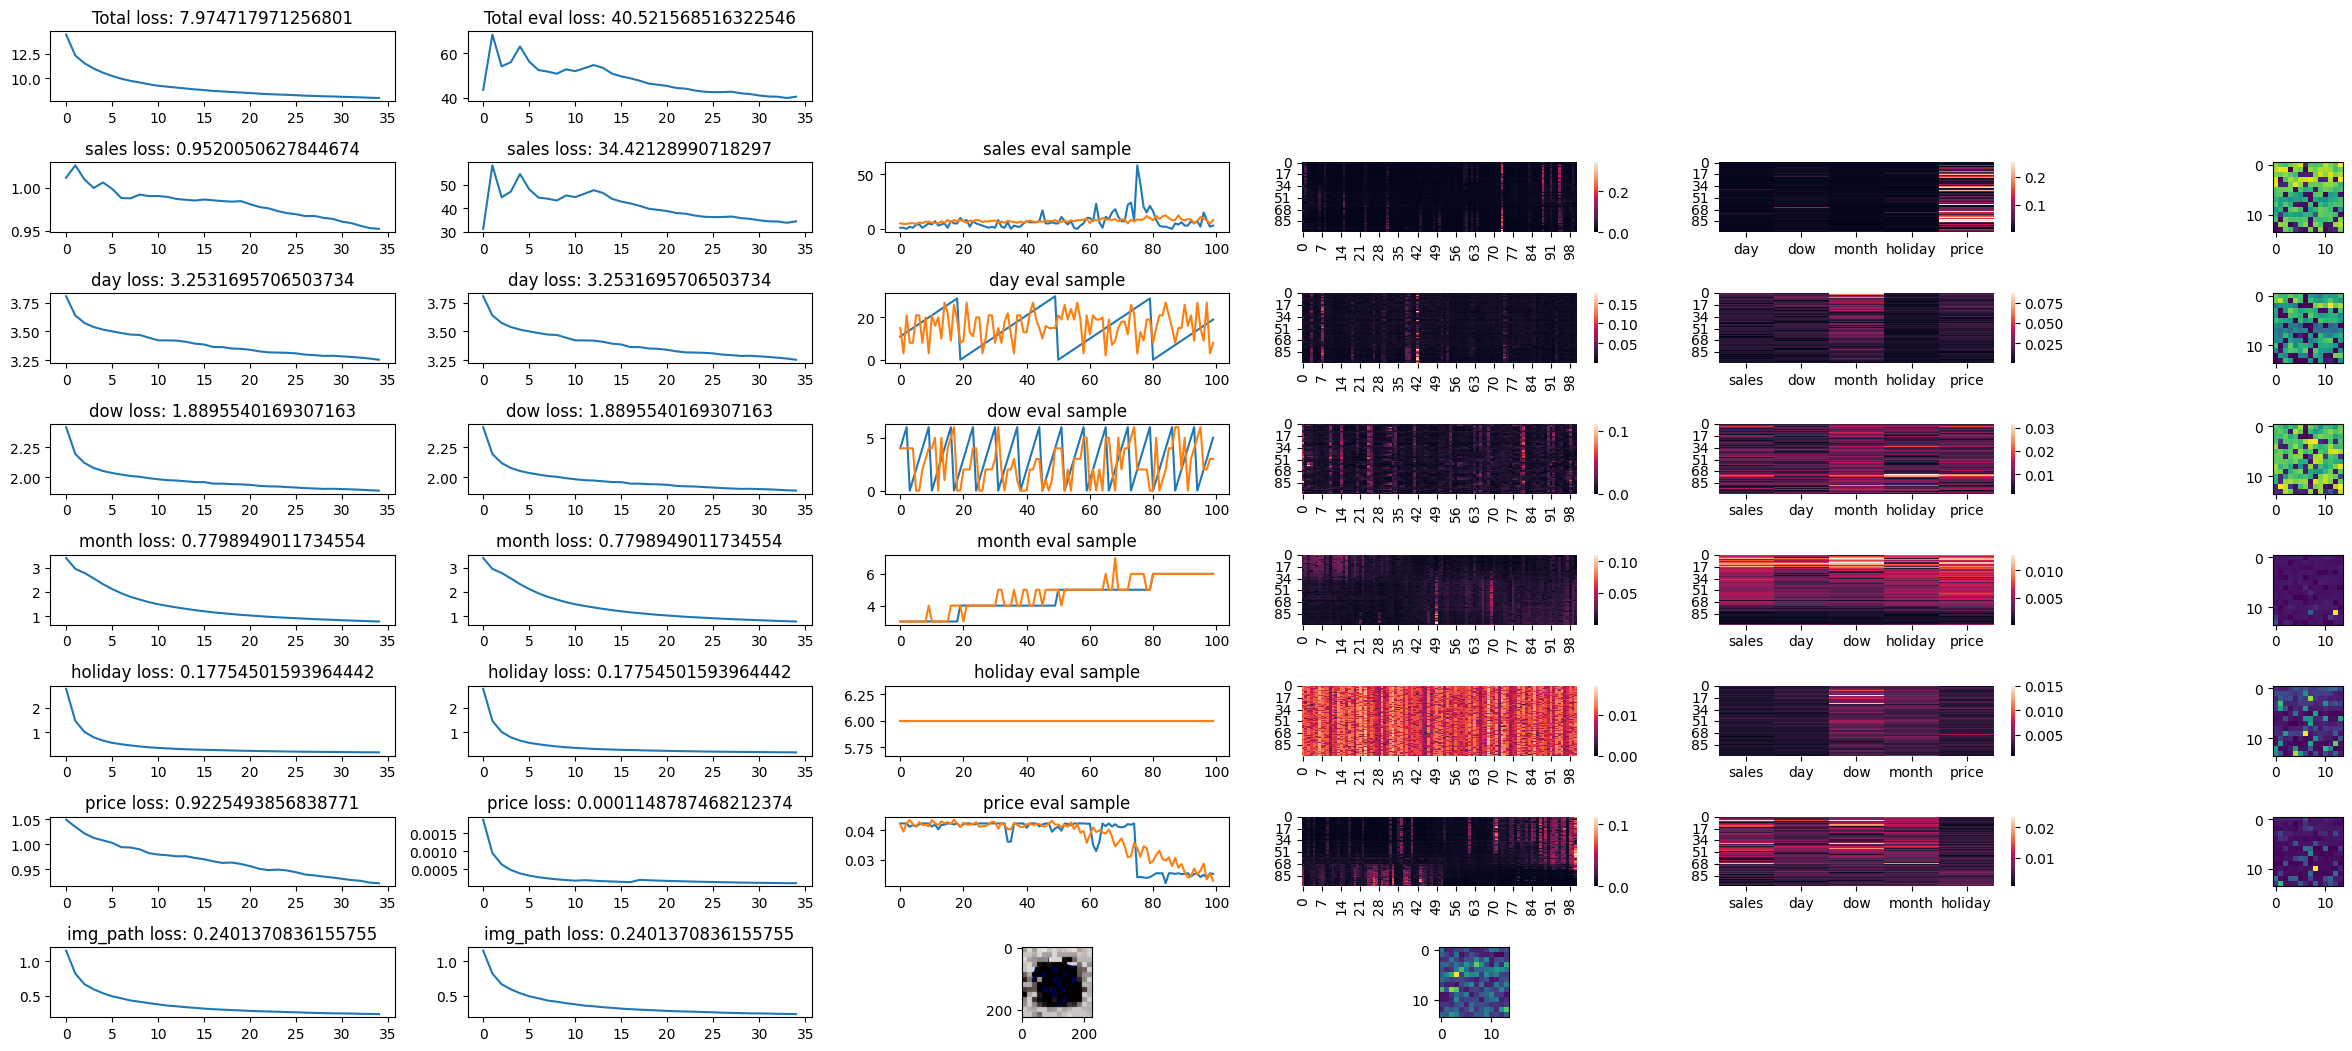

 75%|███████▍  | 684/915 [07:22<03:18,  1.16it/s]

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=False):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    temporal_cols = data_info.modality_info["target"] + data_info.modality_info["temporal"]
    
    for n, col in enumerate(temporal_cols):
        pred = temporal_output[col][:, 1:, :].squeeze()
        y = data[col].to(device).squeeze()

        if inverse_scale and col in data_info.processing_info["scaling_cols"]:
            pred = pred.detach().cpu()
            y = y.detach().cpu()

            new_pred, new_y = [], []
            scaler = data[f"{col}_scaler"]

            for i, s in enumerate(scaler):
                new_pred.append(torch.from_numpy(s.inverse_transform(pred[i].reshape(-1,1).numpy())))
                new_y.append(torch.from_numpy(s.inverse_transform(y[i].reshape(-1,1).numpy())))
            
            new_pred = torch.stack(new_pred, dim=0).squeeze().to(device)
            new_y = torch.stack(new_y, dim=0).squeeze().to(device)
            
            assert new_pred.shape == pred.shape and new_y.shape == y.shape

            pred, y = new_pred, new_y

        if col in data_info.processing_info["scaling_cols"]:
            loss = mse_loss(pred, y)
        elif col in data_info.processing_info["embedding_cols"]:
            pred_ = pred.reshape(-1, pred.shape[-1])
            y_ = y.reshape(-1).to(torch.long)
            loss = ce_loss(pred_, y_).reshape(y.shape)

        # Obtain mask
        padding_mask = padding_mask_dict["temporal_padding_mask"].squeeze().to(torch.int)
        
        mask = idx_dict["temporal_masked_idx"].to(device).to(torch.int)[:, 1:]
        mask = (mask==n).sum(dim=-1)

        mask += padding_mask
        mask = torch.where(mask>1, 1, 0)

        # Get loss
        loss *= mask
        loss = sum(loss.view(-1)) / sum(mask.view(-1))
        loss_dict[col] = loss
        
        # Obtain masked pred and y
        masked_pred_dict[col] = pred
        masked_y_dict[col] = y

    return loss_dict, masked_pred_dict, masked_y_dict

def get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in img_output.items():
        pred = val[:, 1:, :]
        y = patchify(data[key]).to(device)

        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])

        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        loss = mse_loss(masked_pred, masked_y).mean()
        loss_dict[key] = loss

        masked_y_dict[key] = masked_y
        masked_pred_dict[key] = masked_pred
        
    return loss_dict, masked_pred_dict, masked_y_dict

def get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in nlp_output.items():
        pred = val[:, 1:, :].squeeze()
        y = data[key].to(device)[:, 1:, :].squeeze()
        
        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()

        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
        masked_y = masked_y.reshape(-1).to(torch.long)

        loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)
        loss = loss * padding_mask
        loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
        loss_dict[key] = loss

        masked_pred_dict[key] = masked_pred.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        masked_y_dict[key] = masked_y.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        
    return loss_dict, masked_pred_dict, masked_y_dict

def plot_loss(key, temporal_loss_dict, loss_li_dict, mean_loss_li_dict):
    sample_loss = temporal_loss_dict[key].item()
    loss_li_dict[key].append(sample_loss)
    mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())
    plt.plot(mean_loss_li_dict[key])
    plt.title(f"{key} loss: {mean_loss_li_dict[key][-1]}")
    
    return loss_li_dict, mean_loss_li_dict

def plot_temporal(temporal_output, data_info, idx, data,
                    temporal_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict,
                    self_attn_dict, cross_attn_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(temporal_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, temporal_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot eval sample
        plt.subplot(nrows, ncols, plot_idx)
        eval_sample_y = eval_temporal_masked_y_dict[key].detach().cpu()
        eval_sample_pred = eval_temporal_masked_pred_dict[key].detach().cpu()
        if key in data_info.processing_info["embedding_cols"]:
            eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)
        plt.plot(eval_sample_y[idx], label="y")
        plt.plot(eval_sample_pred[idx], label="pred")
        plt.title(f"{key} eval sample")
        plot_idx += 1

        # Plot self heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = self_attn_dict[key][idx].mean(dim=0).detach().cpu()
        sns.heatmap(weight)
        plot_idx += 1

        # Plot cross heatmap
        weight = cross_attn_dict[key][idx].mean(dim=0).squeeze().detach().cpu()
        # weight = cross_attn_dict[key][idx].min(dim=0).values.squeeze().detach().cpu()

        # Temporal
        plt.subplot(nrows, ncols, plot_idx)
        temporal_weight_dict = {}
        start_idx = 0
        for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            if col == key: continue
            temporal_weight_dict[col] = weight[:, start_idx:start_idx+1]
            start_idx += 1

        temporal_weight = torch.cat(list(temporal_weight_dict.values()), dim=-1)
        ax = sns.heatmap(temporal_weight)
        ax.set_xticklabels(temporal_weight_dict.keys())
        plot_idx += 1

        # Img
        plt.subplot(nrows, ncols, plot_idx)
        length = 14*14 + 1
        patch_size = 16
        for col in data_info.modality_info["img"]:
            img_weight = weight[:, start_idx:start_idx+length][0, 1:].numpy()
            img_weight = img_weight.reshape(224//patch_size,224//patch_size)
            # img_weight = cv2.resize(img_weight / img_weight.max(), data[f"{col}_raw"][idx].size)[..., np.newaxis]
            plt.imshow(img_weight)
            plot_idx += 1
            start_idx += length

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def plot_img(img_output, data_info, idx, data,
                    img_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_img_masked_pred_dict, eval_img_masked_y_dict,
                    self_attn_dict, cross_attn_dict, idx_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(img_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, img_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot eval sample
        plt.subplot(nrows, ncols, plot_idx)
        eval_sample_y = patchify(data[key])[idx]
        eval_sample_pred = eval_img_masked_pred_dict[key].detach().cpu()[idx]
        masked_idx = idx_dict[f"{key}_masked_idx"][idx]

        eval_sample_y[masked_idx] = eval_sample_pred
        eval_sample_y = unpatchify(eval_sample_y.unsqueeze(0))
        eval_sample_y = torch.permute(eval_sample_y.squeeze(), (1,2,0))
        plt.imshow(eval_sample_y)
        plot_idx += 1

        # Plot self heatmap
        plt.subplot(nrows, ncols, plot_idx)
        patch_size = 16
        weight = self_attn_dict[key][idx]
        weight = torch.mean(weight, dim=0).squeeze().detach().cpu()
        # weight = torch.min(weight, dim=0).values.squeeze().detach().cpu()
        weight = weight.numpy()
        weight = weight[1:].reshape(224//patch_size,224//patch_size)
        # weight = cv2.resize(weight / weight.max(), data[f"{key}_raw"][idx].size)[..., np.newaxis]
        plt.imshow(weight)
        plot_idx += 3

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def plot_nlp(nlp_output, data_info, idx, data,
                    nlp_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict,
                    self_attn_dict, cross_attn_dict, idx_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(nlp_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, nlp_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot sample
        eval_sample_y = torch.tensor(tokenizer(data[f"{key}_raw"][idx])["input_ids"])
        eval_sample_pred = eval_nlp_masked_pred_dict[key].detach().cpu()
        eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)[idx]
        
        remain_idx = idx_dict[f"{key}_remain_idx"][idx]
        masked_idx = idx_dict[f"{key}_masked_idx"][idx]

        eval_sample_full = torch.zeros(idx_dict[f"{key}_revert_idx"].shape)[idx].to(torch.int)

        eval_sample_full[masked_idx] = eval_sample_pred.to(torch.int)

        print(tokenizer.decode(eval_sample_y))
        print(tokenizer.decode(eval_sample_full))

        # Plot heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = cross_attn_dict[key][idx]
        weight = weight.squeeze()[:, len(data_info.modality_info["target"]+data_info.modality_info["temporal"])+(14*14+1):]
        ax = sns.heatmap(weight.detach().cpu())

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    eval_loss_li_dict, eval_mean_loss_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        temporal_output, img_output, nlp_output, self_attn_dict, cross_attn_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)
        
        temporal_loss_dict, temporal_masked_pred_dict, temporal_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info)
        img_loss_dict, img_masked_pred_dict, img_masked_y_dict = get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info)
        nlp_loss_dict, nlp_masked_pred_dict, nlp_masked_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info)

        temporal_total_loss = torch.nansum(torch.stack(list(temporal_loss_dict.values())))
        try :
            img_total_loss = torch.nansum(torch.stack(list(img_loss_dict.values())))
        except:
            img_total_loss = torch.tensor([0]).to(device)

        try:
            nlp_total_loss = torch.nansum(torch.stack(list(nlp_loss_dict.values())))
        except: 
            nlp_total_loss = torch.tensor([0]).to(device)
        
        temporal_loss_dict["total"] = temporal_total_loss
        img_loss_dict["total"] = img_total_loss
        nlp_loss_dict["total"] = nlp_total_loss

        loss = temporal_total_loss + img_total_loss + nlp_total_loss
        loss.backward()
        optimizer.step()

        # Eval
        model.eval()
        with torch.no_grad():
            eval_temporal_loss_dict, eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=True)
            eval_img_loss_dict, eval_img_masked_pred_dict, eval_img_masked_y_dict = get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info)
            eval_nlp_loss_dict, eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info)
        eval_temporal_loss = torch.nansum(torch.stack(list(eval_temporal_loss_dict.values())))
        try:
            eval_img_loss = torch.nansum(torch.stack(list(eval_img_loss_dict.values())))
        except: 
            eval_img_loss = torch.tensor([0]).to(device)
        
        try:
            eval_nlp_loss = torch.nansum(torch.stack(list(eval_nlp_loss_dict.values())))
        except:
            eval_nlp_loss = torch.tensor([0]).to(device)
        
        eval_temporal_loss_dict["total"] = eval_temporal_loss
        eval_img_loss_dict["total"] = eval_img_loss
        eval_nlp_loss_dict["total"] = eval_nlp_loss

        # Plot
        if n % 20 == 0:
            plt.figure(figsize=(25,13))
            clear_output(wait=True)
            nrows, ncols = 10, 6

            # Plot total loss
            plt.subplot(nrows, ncols, 1)
            total_loss = temporal_loss_dict["total"].item()
            loss_li_dict["total"].append(total_loss)
            mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())
            plt.plot(mean_loss_li_dict["total"])
            plt.title(f'Total loss: {mean_loss_li_dict["total"][-1]}')

            # Plot eval total loss
            plt.subplot(nrows, ncols, 2)
            eval_total_loss = eval_temporal_loss_dict["total"].item()
            eval_loss_li_dict["total"].append(eval_total_loss)
            eval_mean_loss_li_dict["total"].append(np.array(eval_loss_li_dict["total"]).mean())
            plt.plot(eval_mean_loss_li_dict["total"])
            plt.title(f'Total eval loss: {eval_mean_loss_li_dict["total"][-1]}')

            # Plot sample
            plot_idx = 7
            idx = 0
            loss_li_dict, mean_loss_li_dict,\
                eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_temporal(temporal_output, data_info, idx, data,
                                                                            temporal_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                            eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                            eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict,
                                                                            self_attn_dict, cross_attn_dict,
                                                                            nrows, ncols, plot_idx)
            
            loss_li_dict, mean_loss_li_dict,\
                eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_img(img_output, data_info, idx, data,
                                                                            img_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                            eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                            eval_img_masked_pred_dict, eval_img_masked_y_dict,
                                                                            self_attn_dict, cross_attn_dict, idx_dict,
                                                                            nrows, ncols, plot_idx)

            loss_li_dict, mean_loss_li_dict,\
                            eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_nlp(nlp_output, data_info, idx, data,
                                                                                        nlp_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                                        eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                                        eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict,
                                                                                        self_attn_dict, cross_attn_dict, idx_dict,
                                                                                        nrows, ncols, plot_idx)

            plt.tight_layout()
            plt.show()

epoch = 3
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise